# Notebook M06 - Plume problem

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [15]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("StokesCylindrical.jl")

include("Temperature.jl")
include("TemperatureCylindrical.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

- Lithosphere with initial geotherm set by plate cooling

In [16]:
# problem set-up
using SpecialFunctions
# function to define plate cooling solution
function plate_cooling(Tsurf,Tbtm,yL0,kappa,y,t)
   # y is a vector of y coordinates where we need the solution
    T = Tsurf .+ (Tbtm-Tsurf) .* (y/yL0)
    for n in 1:20 # note 20 is an index in a summation from 1 to Inf
        T += (Tbtm-Tsurf)*2/pi .* 1/n*exp(-kappa*n^2*pi^2*t/yL0^2)*sin(n*pi*y/yL0)
    end
    return T
end

function halfspace_cooling(Tsurf,Tmantle,kappa,y,t)
    if t == 0.0
        if y==0.0
            return Tsurf
        else
            return Tmantle
        end
    else
        T = Tsurf + (Tmantle-Tsurf)*erf(y/2/sqrt(kappa*t))         
        return T
    end
end

function halfspace_cooling_from_thickness(Tsurf,Tmantle,kappa,y,thickness)
    t = (thickness/2)^2/kappa
    return halfspace_cooling(Tsurf,Tmantle,kappa,y,t)
end

# function to compute solidus and liquidus

# function to compute melt fraction

# function to compute viscosity
function viscosity(eta0::Float64,T::Float64,E::Float64 ; visc_max=1.0e25)
   # E should be given in J/mol/K
   # Expect all temperatures in kelvin.
   Tref = 1350.0+273.0
   R = 8.314 #J/mol/K
   viscosity = eta0*exp(E/R/Tref*(Tref/T-1))
   if viscosity > visc_max
      viscosity = visc_max
   end
   return viscosity
end

struct Materials
    # 1 - ambient mantle
    # 2 - eclogite
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    Ea::Vector{Float64}
    function Materials()
         new([3e-5,3e-5],[3300.,3300.],[0.0,0.0],[1000.,1000.],[3.0,3.0],[1e21,1e21],[3e5,3e5])
    end
end

function update_marker_properties!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    eta = markers.scalarFields["eta"]
    for i in 1:markers.nmark                
        # re-compute density using the current temperature value
        # assume reference temperature is 273.0
        # markers.scalars[rho,i] = materials.rho0[mmat[i]] # don't update density - for comparison with gerya
        markers.scalars[rho,i] = materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
        markers.scalars[eta,i] = viscosity(materials.eta[mmat[i]],markers.scalars[T,i],materials.Ea[mmat[i]])
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    # Define geometric properties
    lithosphere_thickness = 1.5e5
    mantle_temperature = 1350.0
    
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-0)^2 + (my-2.85e6)^2)^0.5 
        
        # define initial cmb hot layer geometry
        h = 150e3 + (113e3-150e3)*(mx-0.0)/5e5
                
        # set material - eclogite at cmb
        if my > 2.85e6-h
           markers.integers[material,i] = 2
        else
           markers.integers[material,i] = 1
        end
                
        if my < lithosphere_thickness
            markers.scalars[T,i] = plate_cooling(273.0,1350.0+273.0,1.5e5,1e-6,my,100e6*3.15e7)
        else
            markers.scalars[T,i] = halfspace_cooling_from_thickness(2500.0+273.0,1350.0+273.0,1e-6,2.85e6-my,h)
        end
        ind = markers.integers[material,i]
        markers.scalars[eta,i] = viscosity(materials.eta[ind],markers.scalars[T,i],materials.Ea[ind])
        markers.scalars[alpha,i] = materials.alpha[ind]            
        markers.scalars[cp,i] = materials.Cp[ind]  
        markers.scalars[Hr,i] = materials.Hr[ind]  
    end
    update_marker_properties!(markers,materials)
end

initial_conditions! (generic function with 1 method)

In [17]:
# plotting routine
function plume_plots(grid::CartesianGrid,vx,vy,rho,T)
    # make some diagnostic plots using pyplot
    fig, (ax1,ax2,ax3,ax4) = subplots(1,4)
    ax1.pcolor(grid.xc,grid.yc,rho)
    ax1.invert_yaxis()
    ax1.set_title("Density")
    ax1.set_aspect("equal")
    ax2.pcolor(grid.xc,grid.yc,T)
    ax2.invert_yaxis()
    ax2.set_title("Temperature")
        ax2.set_aspect("equal")

    ax3.pcolor(grid.xc,grid.yc,vx)
    ax3.invert_yaxis()
    ax3.set_title("vx")
        ax3.set_aspect("equal")

    ax4.pcolor(grid.xc,grid.yc,vy)
    ax4.invert_yaxis()
    ax4.set_title("vy")
        ax4.set_aspect("equal")

    fig.show()
end


plume_plots (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat previous step.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 4th order Runge-Kutta

TO DO:
1. Calculate rhox (rho at vx points) -> (optionally) pass to Stokes.jl (Max)
3. Add free-surface stabilization terms to Stokes.jl (Lucy)
4. Add functionality for shear heating (Max)
5. Add functionality for adiabatic heating (Uthkarsh)

Creating Markers...
  0.000093 seconds (18 allocations: 318.609 KiB)
Initial condition...
  0.005519 seconds (104.75 k allocations: 1.606 MiB)
Trying with timestep 1.0 Myr
dTmax=0.8801541375878514 dt=1.0
dT_remaining max (20.6588617948177, 63.38913748845679)
marker temperature max 2571.338847847567 min 577.4625710805362
marker density max 3271.2927093735566 min 3070.9017046672375
Writing visualization fle plume/viz.0000.vtr
Min/Max velocity: -1.9291892214041776e-10 1.4170375985311254e-10
Finished Step 1 time=1.0 Myr
Trying with timestep 1.0 Myr
dTmax=0.8796324714417096 dt=1.0
dT_remaining max (20.88040174705297, 62.89049818365434)
marker temperature max 2557.7602967235666 min 591.6825544384285
marker density max 3269.858205463027 min 3072.464454063091
Writing visualization fle plume/viz.0001.vtr
Min/Max velocity: -2.3751294163860546e-10 1.748542888718541e-10
Finished Step 2 time=2.0 Myr
Trying with timestep 1.0 Myr
dTmax=0.8791381732769423 dt=1.0
dT_remaining max (21.098147019109696, 6

dT_remaining max (-196.00862372000105, 158.35479881233368)
marker temperature max 2529.408091901145 min 723.5858443186228
marker density max 3255.602526348201 min 3077.308620635019
Min/Max velocity: -2.253385764746818e-8 1.2111576284675554e-8
Finished Step 27 time=12.294079342257874 Myr
Trying with timestep 0.1976785680402432 Myr
dTmax=1.5133564034044866 dt=0.1976785680402432
dT_remaining max (-225.93106712965147, 140.48800687649145)
marker temperature max 2532.749014862332 min 725.8808303211998
marker density max 3255.3920014124565 min 3076.6155989017866
Writing visualization fle plume/viz.0012.vtr
Min/Max velocity: -2.080424880312203e-8 1.0998574823983063e-8
Finished Step 28 time=12.491757910298118 Myr
Trying with timestep 0.2062596784100868 Myr
dTmax=1.5775579780561202 dt=0.2062596784100868
dT_remaining max (-253.1916082482265, 147.29166418628483)
marker temperature max 2533.3943248332066 min 728.2662977953722
marker density max 3255.164797798201 min 3076.284847528629
Min/Max veloci

dT_remaining max (-216.14201244133127, 130.9804899400583)
marker temperature max 2390.8564534540533 min 823.695981089027
marker density max 3246.122841718932 min 3089.1024602599537
Min/Max velocity: -6.215056651530633e-9 3.283507788289707e-9
Finished Step 53 time=21.68947178842829 Myr
Trying with timestep 0.6872976534696434 Myr
dTmax=4.341404190290859 dt=0.6872976534696434
dT_remaining max (-223.53701487417405, 176.76894786309595)
marker temperature max 2378.1730828479813 min 830.3437253769741
marker density max 3245.4810978721866 min 3090.332211108049
Writing visualization fle plume/viz.0020.vtr
Min/Max velocity: -5.983658014534102e-9 3.1211863510262087e-9
Finished Step 54 time=22.37676944189793 Myr
Trying with timestep 0.635746762301173 Myr
dTmax=4.023051909097376 dt=0.635746762301173
dT_remaining max (-227.17295927039376, 166.27407335890166)
marker temperature max 2366.618443576414 min 836.4177466240046
marker density max 3244.8229711876793 min 3091.58786479805
Min/Max velocity: -6.

dT_remaining max (-114.67398960983269, 114.67398960983292)
marker temperature max 2060.677258140237 min 1010.5518386017369
marker density max 3227.6050400452455 min 3122.0074954930847
Writing visualization fle plume/viz.0039.vtr
Min/Max velocity: -2.6817153663127526e-9 1.2268708465027701e-9
Finished Step 79 time=45.49520861295828 Myr
Trying with timestep 1.0 Myr
dTmax=3.447981256344974 dt=1.0
dT_remaining max (-90.705696998967, 84.98547617381337)
marker temperature max 2050.6769859622236 min 1016.725140955155
marker density max 3226.982367978428 min 3123.0199514441165
Writing visualization fle plume/viz.0040.vtr
Min/Max velocity: -2.5532361115281115e-9 1.2890954010187515e-9
Finished Step 80 time=46.49520861295828 Myr
Trying with timestep 1.0 Myr
dTmax=3.6886404576098357 dt=1.0
dT_remaining max (-130.54958192261643, 130.43076252572357)
marker temperature max 2040.9303731783693 min 1022.7842308108462
marker density max 3226.37121104544 min 3124.00997838974
Writing visualization fle plume

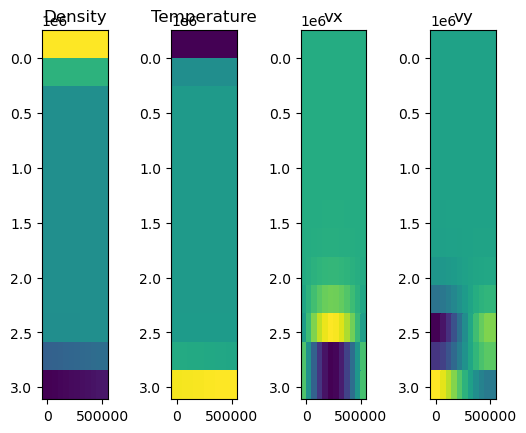

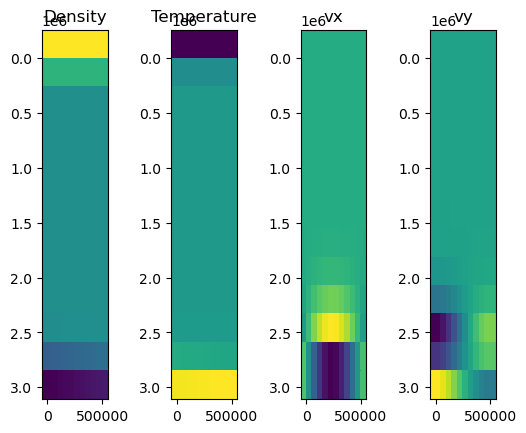

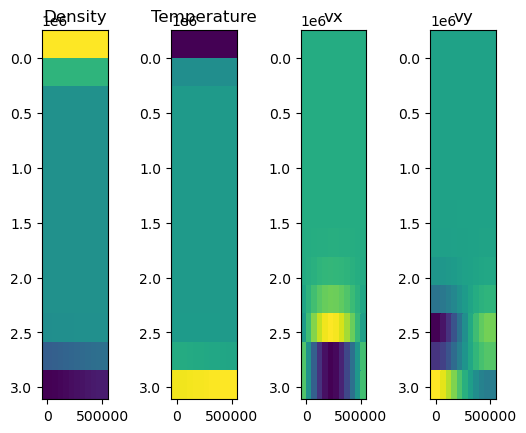

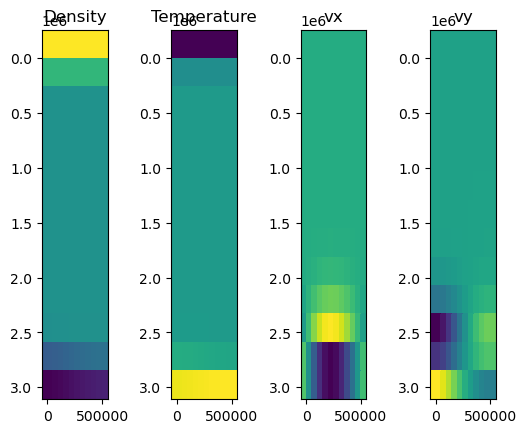

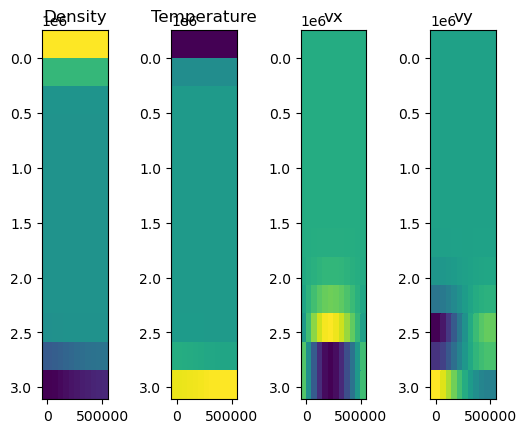

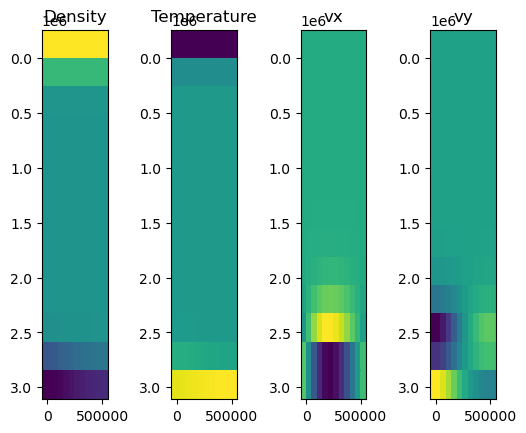

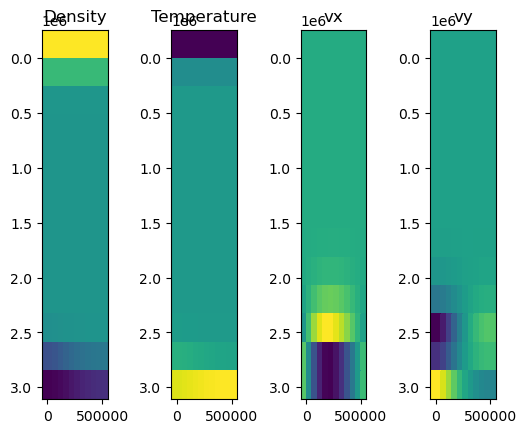

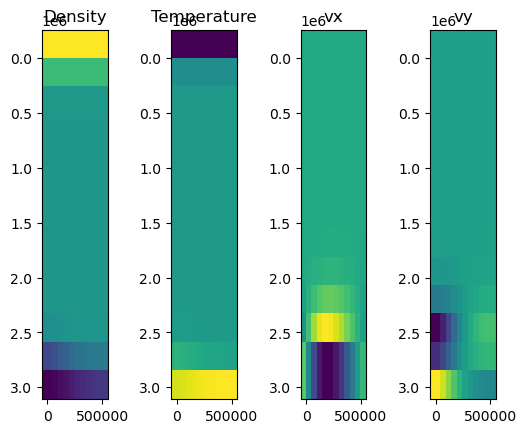

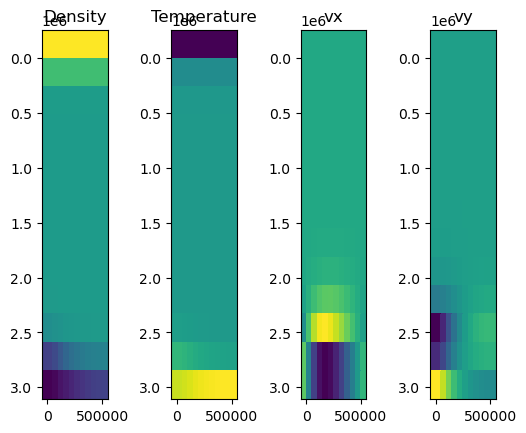

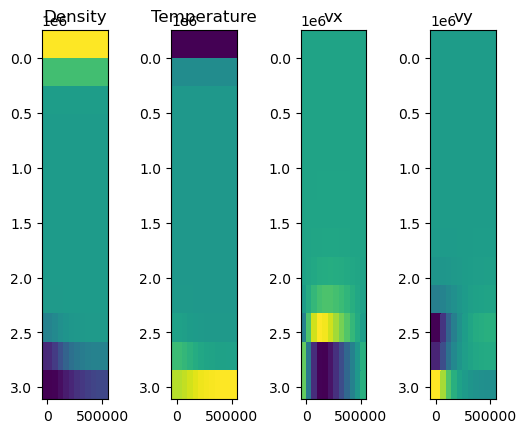

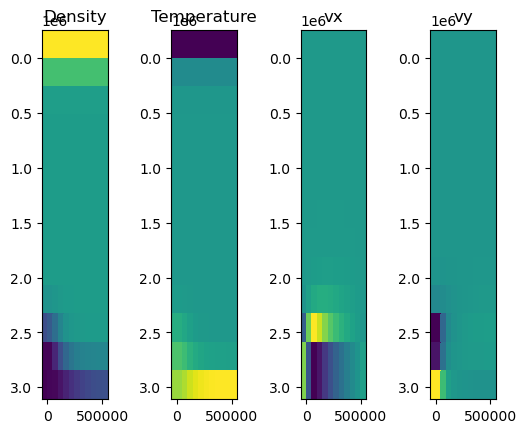

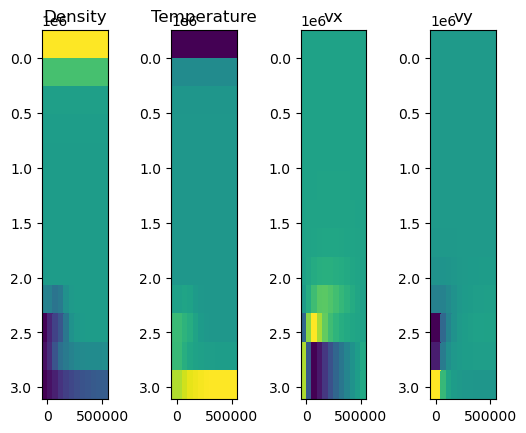

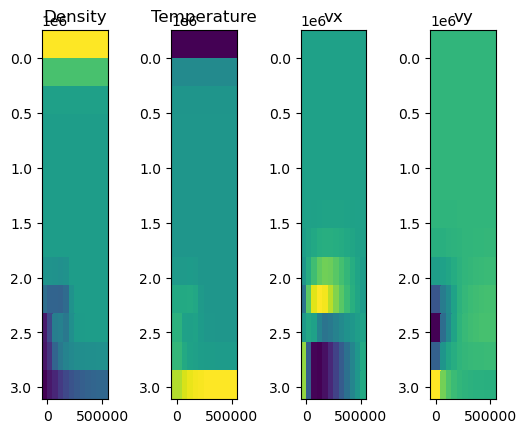

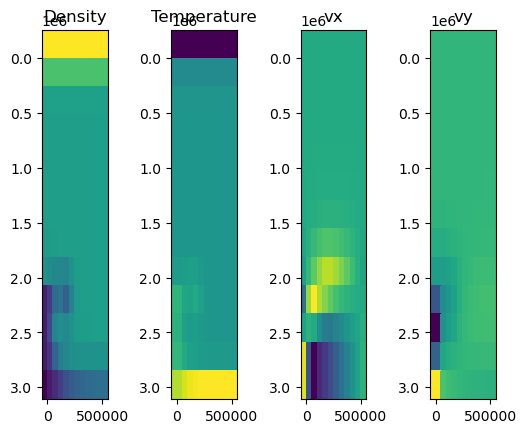

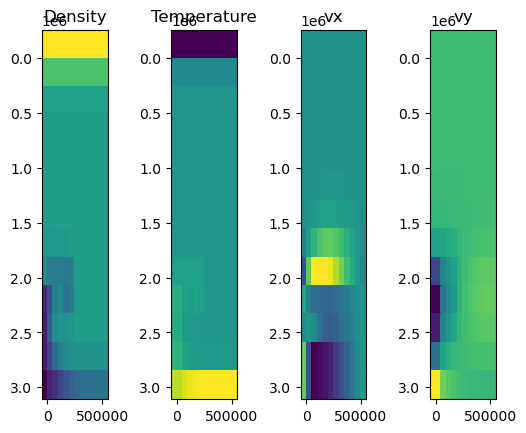

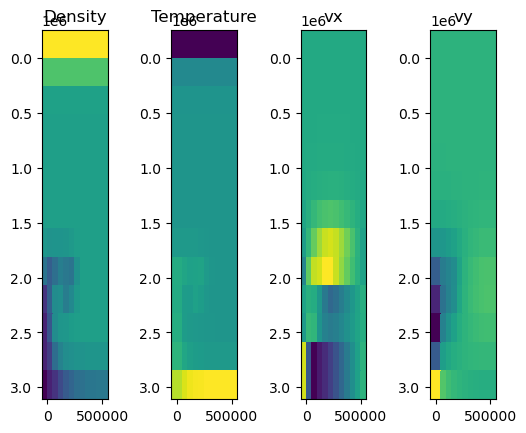

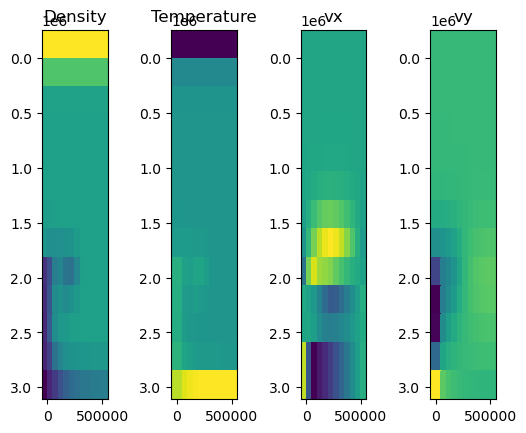

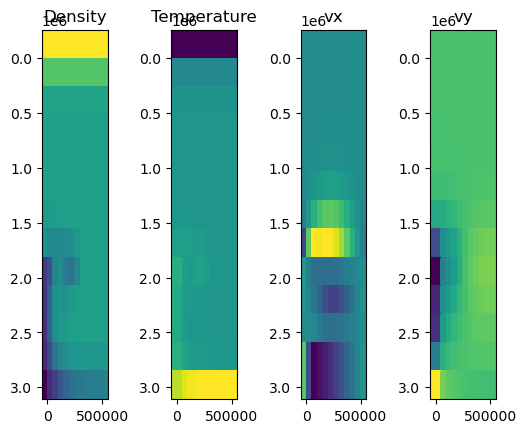

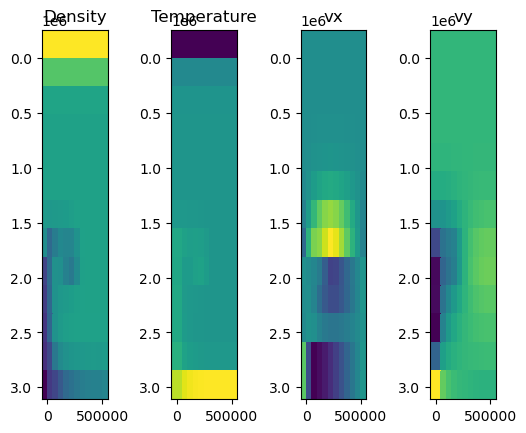

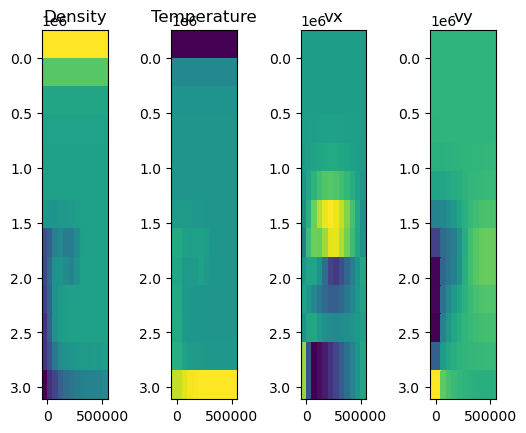

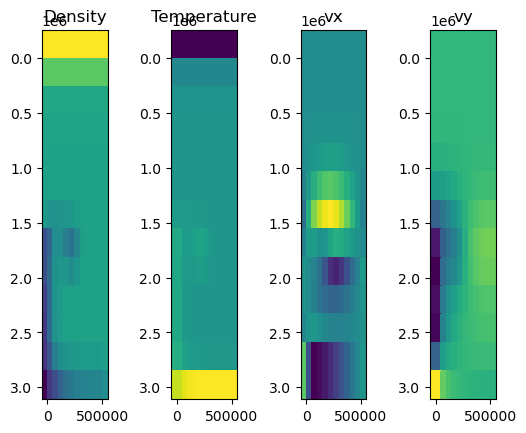

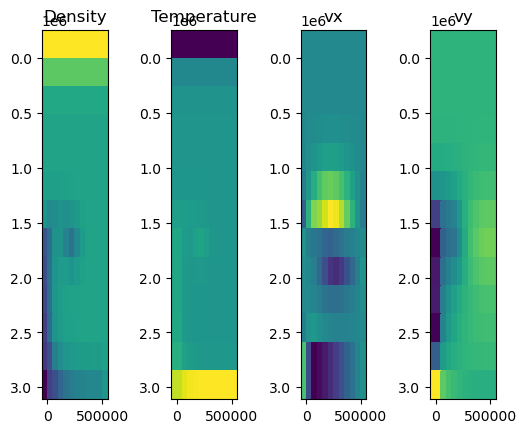

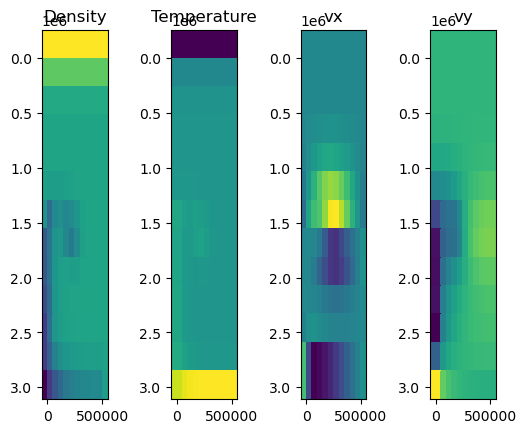

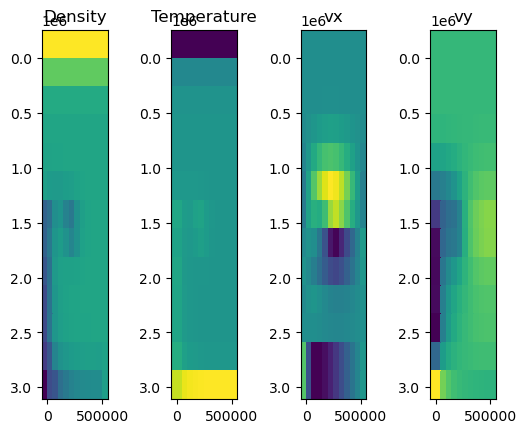

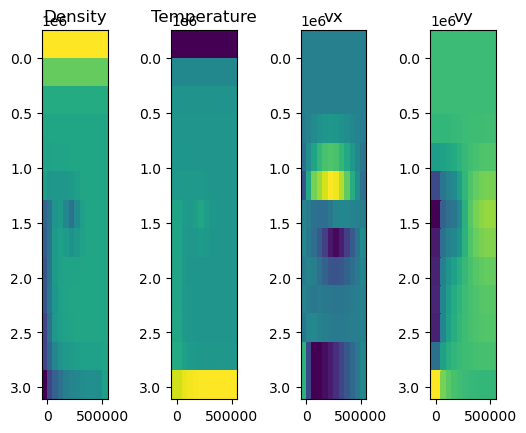

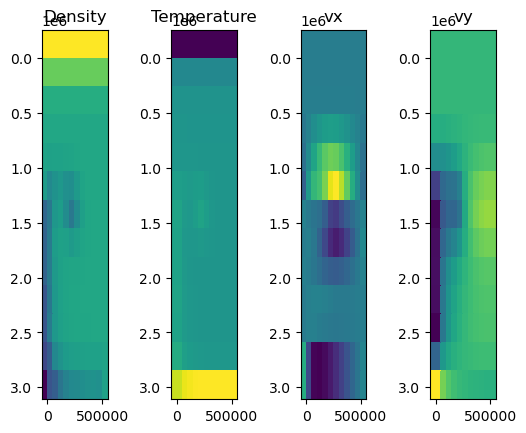

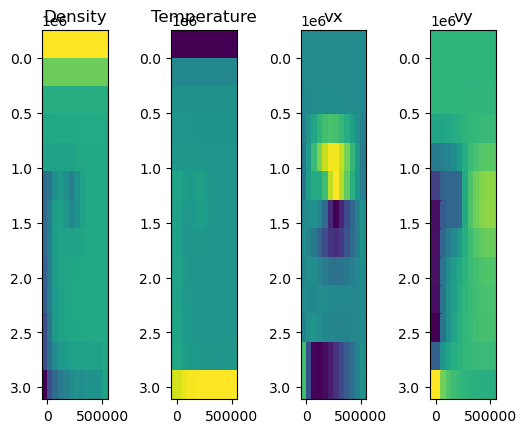

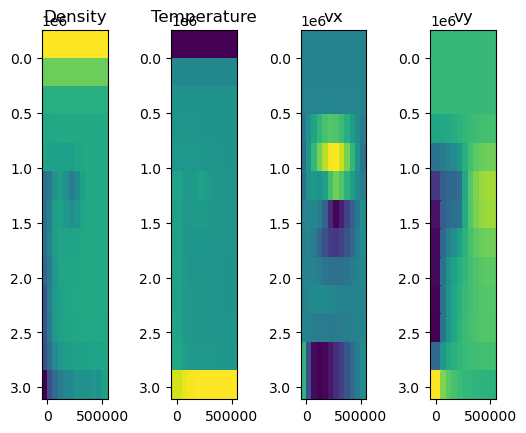

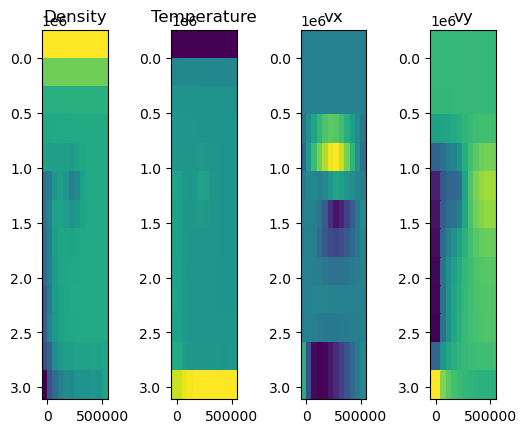

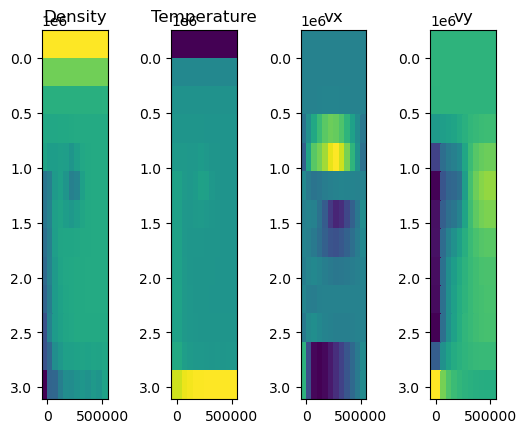

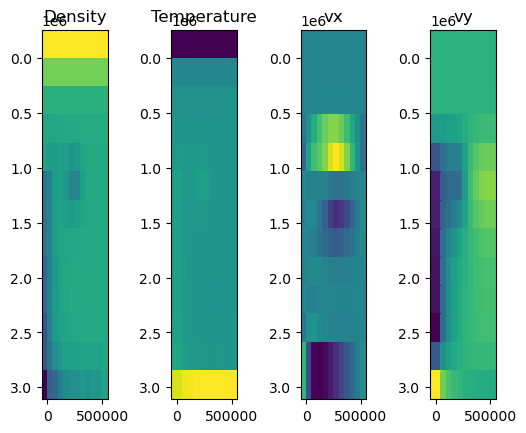

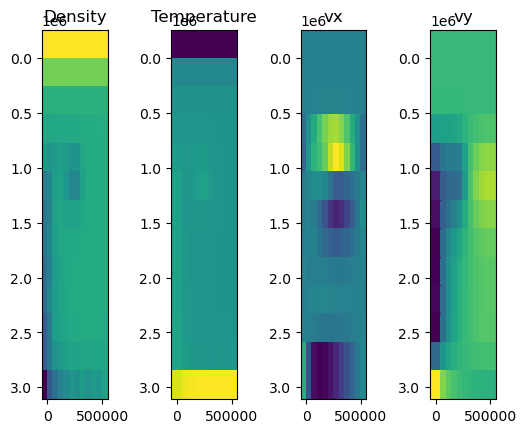

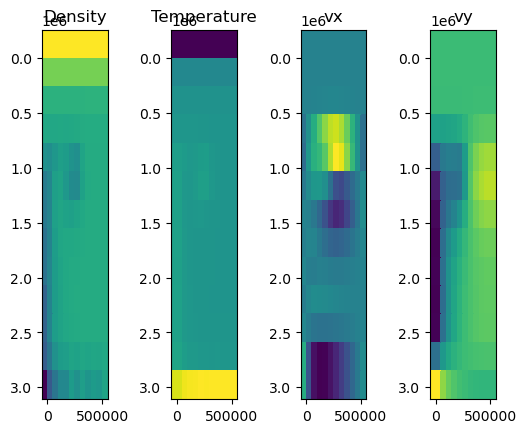

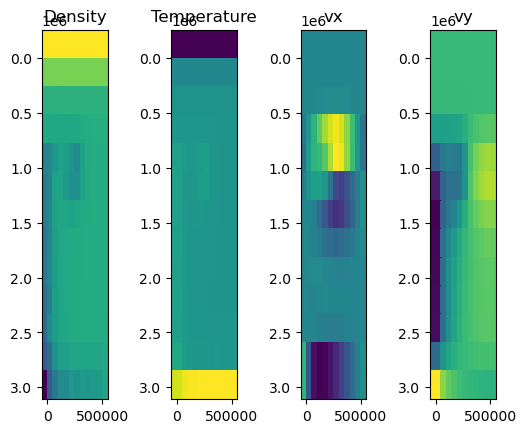

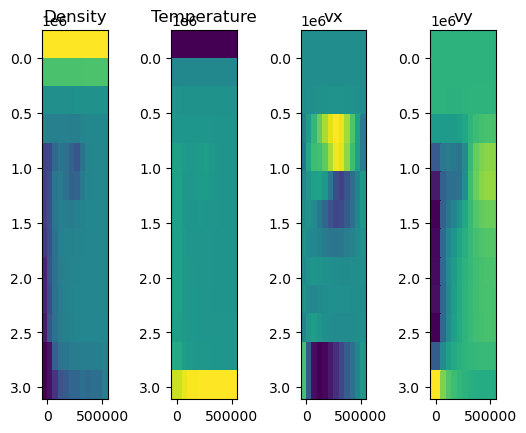

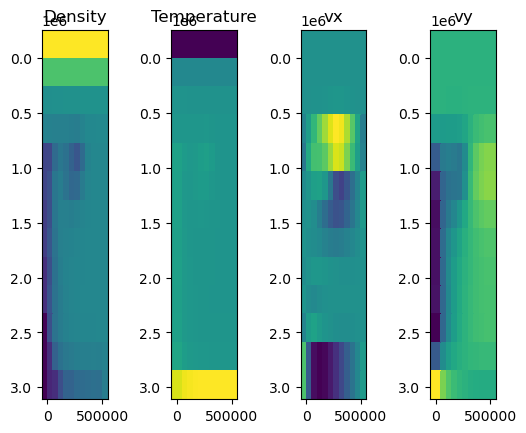

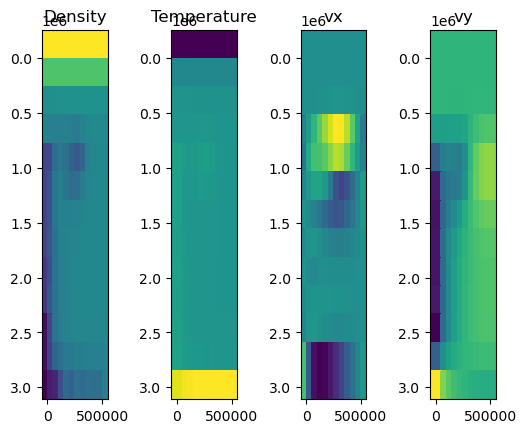

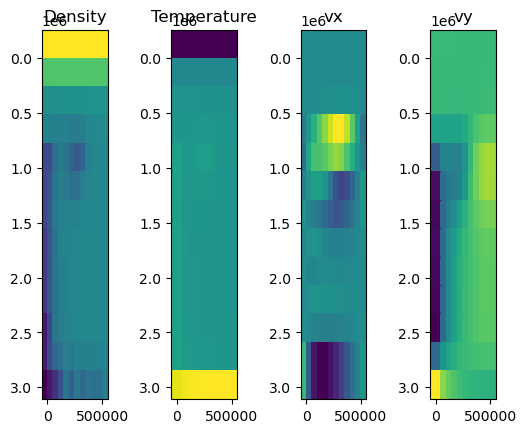

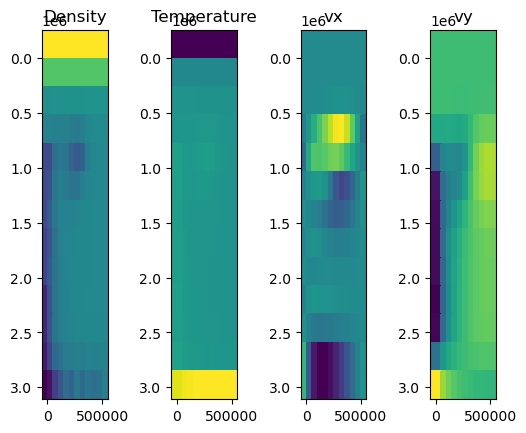

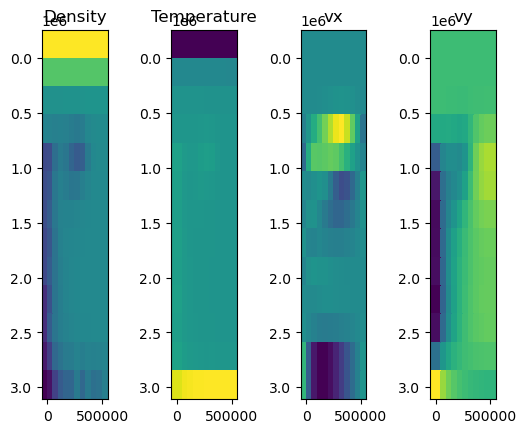

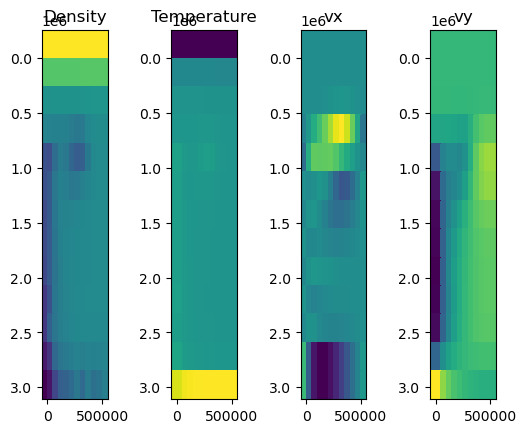

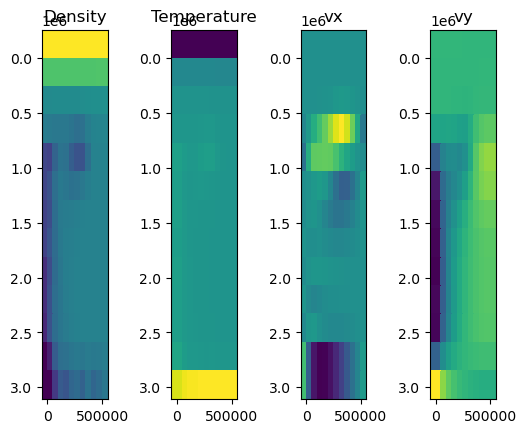

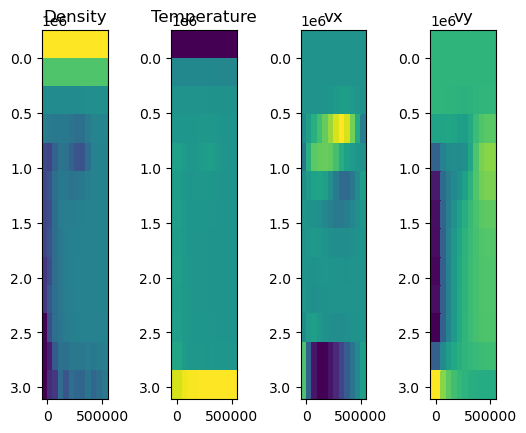

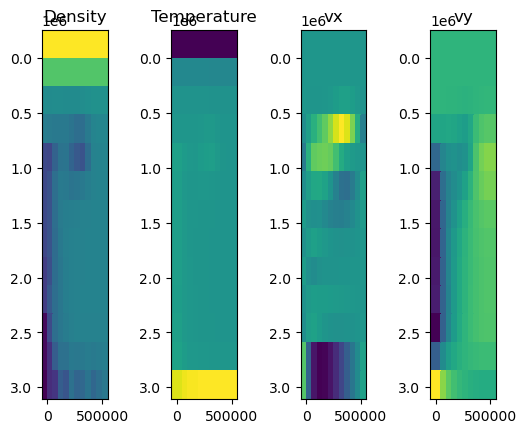

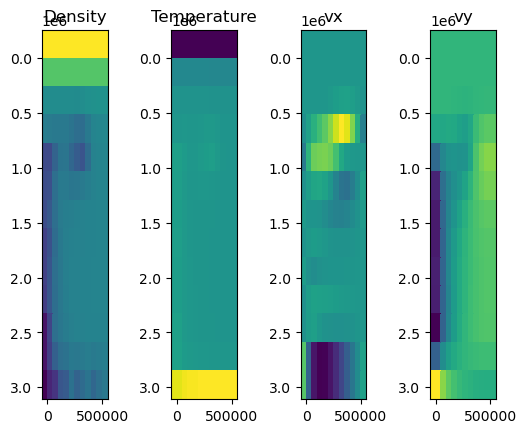

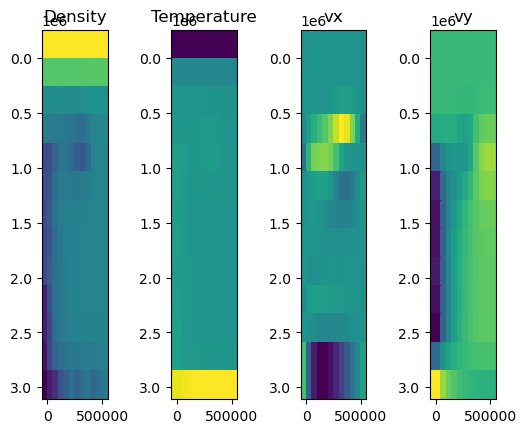

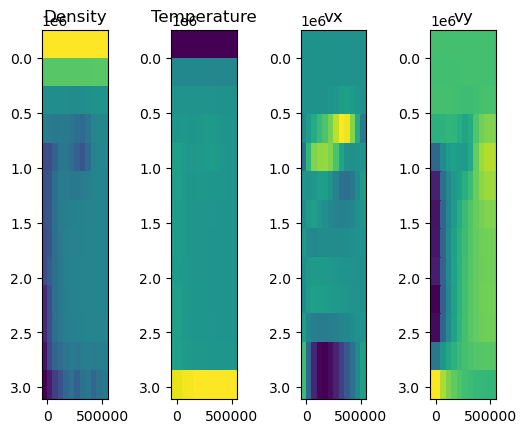

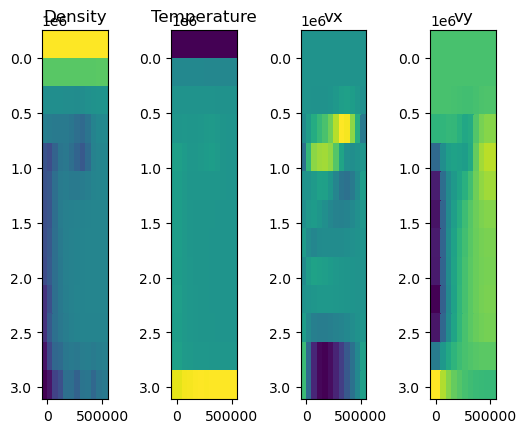

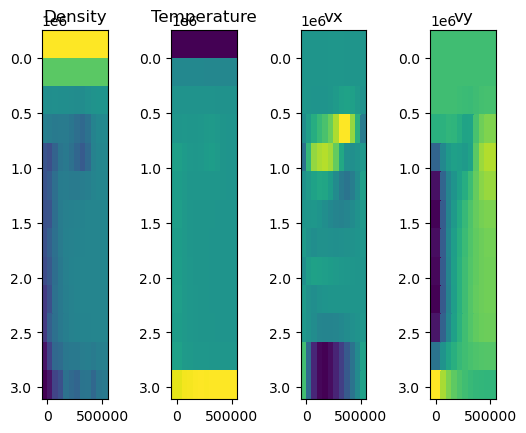

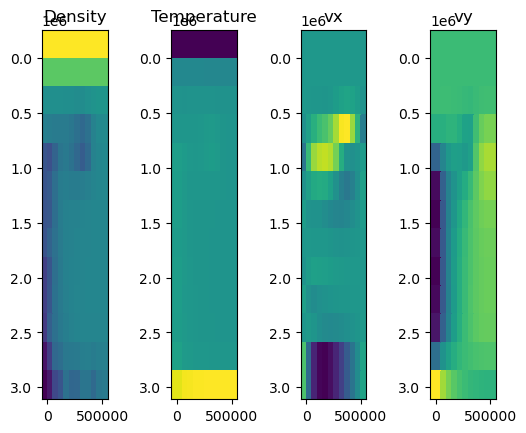

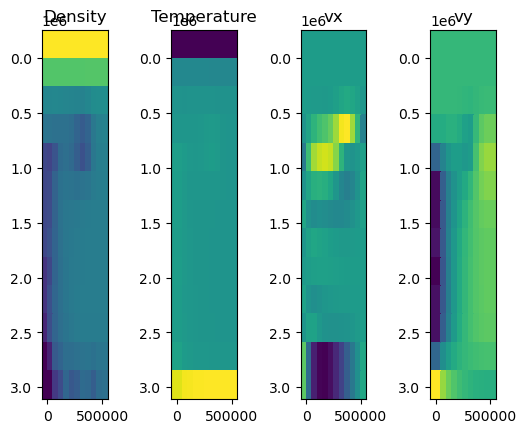

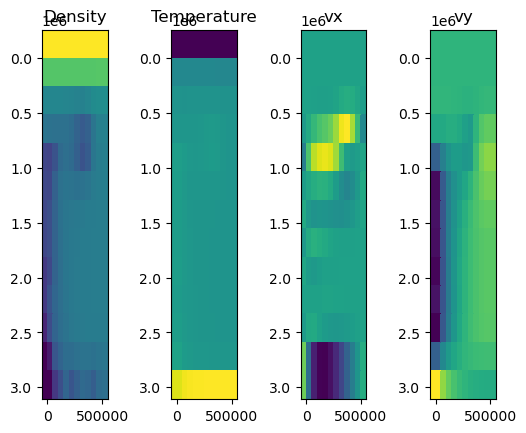

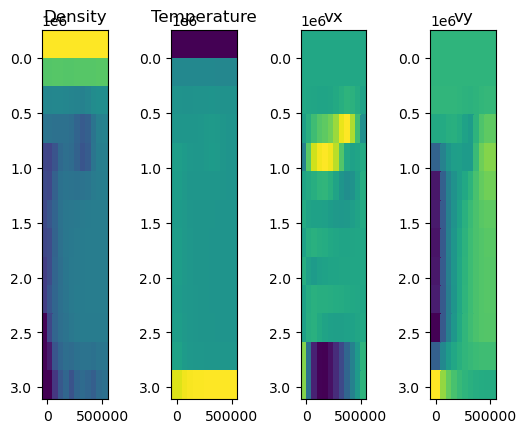

Figure(PyObject <Figure size 640x480 with 4 Axes>)

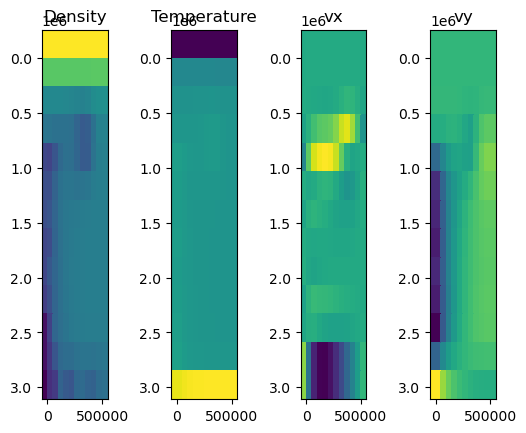

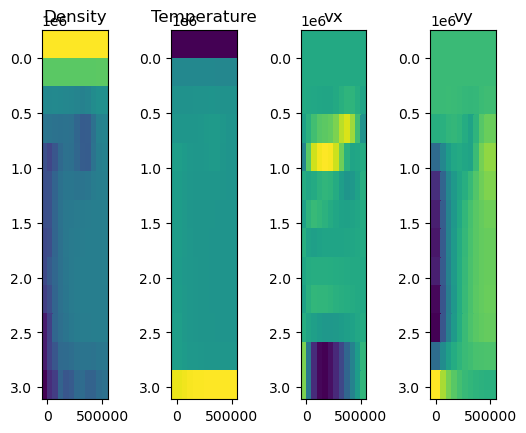

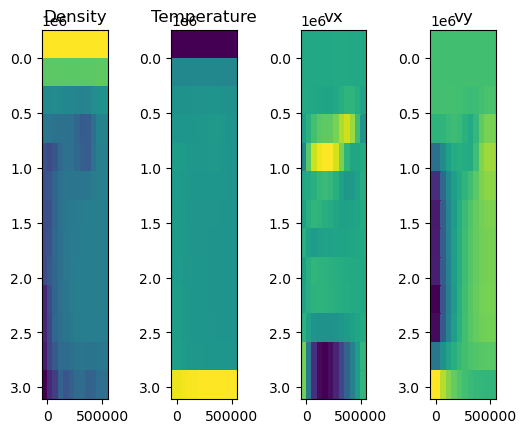

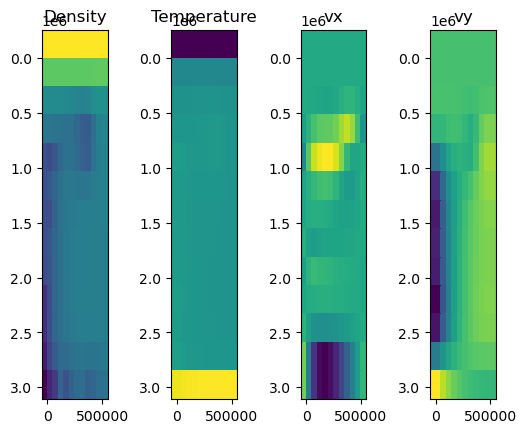

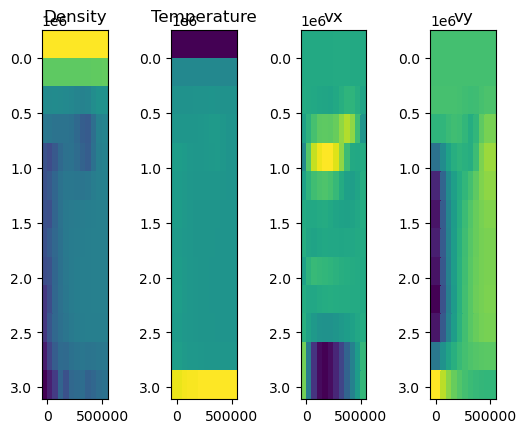

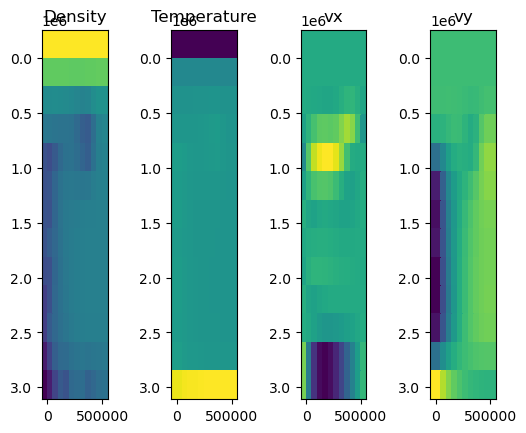

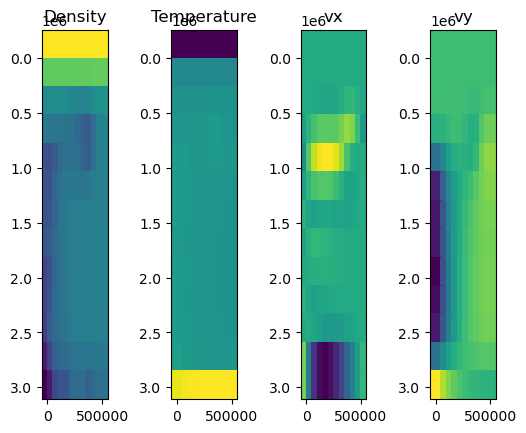

In [18]:
function plume_model(nstep::Int64)
# nstep=1
    nx = 11#51
    ny = 12#285
    W = 5e5
    H = 2.850e6
    gx = 0.0
    gy = 10.0

    Tbcval = [0.0,0.0,273.0,2500.0+273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 5e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","Cp","T","rho","eta","Hr"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 1e10

      local rho_c
      local rho_vx
      local rho_vy
      local alpha
      local Hr
      local Cp_c
      local eta_s
      local eta_n
      local eta_vx
      local eta_vy
      local vx,vy
      local vxc=nothing
      local vyc=nothing
      local T
      local dt
      local dTmax
      local dTemp
      local Tnew=nothing
      local Tlast

     output_dir = "plume"
     itime=1
     for itime in 1:nstep
        update_marker_properties!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_basic_node(markers,grid,["eta",]);
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_cell_center(markers,grid,["rho","Cp","alpha","eta","T","Hr"])
        # 1c. Vx and Vy nodes:
        rho_vx_new,eta_vx_new = marker_to_stag(markers,grid,["rho","eta"],"vx")
        rho_vy_new,eta_vy_new = marker_to_stag(markers,grid,["rho","eta"],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(eta_vx,eta_vx_new)
            replace_nan!(eta_vy,eta_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        eta_vx = copy(eta_vx_new)
        eta_vy = copy(eta_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        Tlast = ghost_temperature_center(grid,Tlast,Tbcval)
        # 2. Assemble and solve the stokes equations
        #L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt=dt)
        L,R = form_stokes_cylindrical(grid,eta_s,eta_n,eta_vx,eta_vy,rho_vx,rho_vy,bc,gx,gy)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer=1
        for titer=1:2# limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            L,R = assemble_energy_equation_cylindrical(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end
        if any(isnan.(markers.scalars[markers.scalarFields["rho"],:]))
            println("nan in density")
            break
        end
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,dTemp,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
        println("dT_remaining max ",extrema(dT_remaining))
        println("marker temperature max ",maximum(markers.scalars[markers.scalarFields["T"],:])," min ",minimum(markers.scalars[markers.scalarFields["T"],:]))
        println("marker density max ",maximum(markers.scalars[markers.scalarFields["rho"],:])," min ",minimum(markers.scalars[markers.scalarFields["rho"],:]))

        if any(isinf.(markers.scalars[markers.scalarFields["T"],:]))
            println("Nan in marker temp")
            break
        end
        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
    
            plume_plots(grid,vxc,vyc,rho_c,Tnew)
    
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=0.0)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
     end
     return grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time
 end
 @time grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time = plume_model(100);


Int64[]

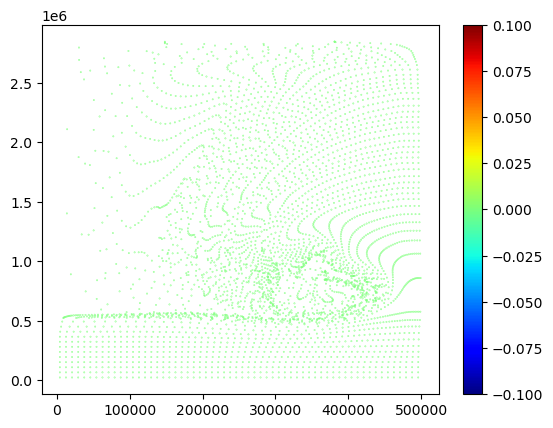

6×0 Matrix{Float64}

In [19]:
figure()
scatter(markers.x[1,:],markers.x[2,:],c=isnan.(markers.scalars[markers.scalarFields["rho"],:]),s=0.1,cmap="jet")
colorbar()
show()

ind = findall(isnan,(markers.scalars[markers.scalarFields["rho"],:]))
print(ind)
markers.scalars[:,ind]

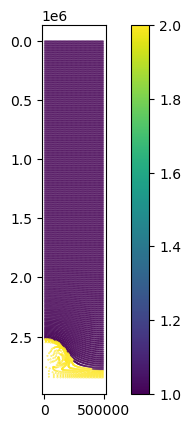

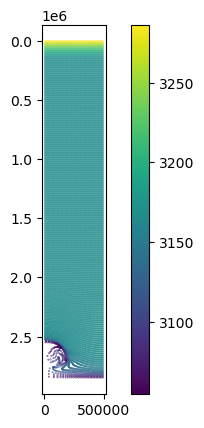

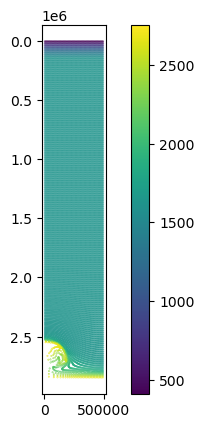

In [6]:
# figure()
# # title(print(time/3.15e7))
# # pcolor(grid.xc,grid.yc,eta_n)
# gca().invert_yaxis()
# colorbar()
# show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=(markers.integers[markers.integerFields["material"],:]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=(markers.scalars[markers.scalarFields["rho"],:]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()


figure()
scatter(markers.x[1,:],markers.x[2,:],c=(markers.scalars[markers.scalarFields["T"],:]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()

In [7]:
# Optionally, run a few steps with the profiler
# using ProfileSVG
# @profview plume_model(10)

In [8]:
minimum(markers.scalars[markers.scalarFields["T"],:])

NaN